In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 크기 조정
    transforms.ToTensor(), # 이미지를 텐서로 변환
])

# ImageFolder를 사용해 전체 데이터셋 로드
data_dir = 'dataset/train/nobreak/nobreak'  # 데이터셋 경로
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# 데이터셋 크기 계산 및 분할
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

# random_split으로 데이터셋 분할
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# 훈련 및 검증 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 데이터 로더를 이용한 데이터 접근 예시
for images, labels in train_loader:
    # 훈련 데이터셋을 사용한 학습 코드
    pass

for images, labels in test_loader:
    # 검증 데이터셋을 사용한 평가 코드
    pass

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # 추가된 층
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)  # 입력 크기 조정
        self.fc2 = nn.Linear(1024, 6)  # 6개의 출력 클래스

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # Flatten 과정
        x = x.view(-1, 256 * 14 * 14)  # Flatten에 맞게 변경
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = DeepCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 훈련 루프
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

    # 검증
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Accuracy after epoch {epoch + 1}: {100 * correct / total}%")

Epoch 1, Loss: 1.7566605372862383
Accuracy after epoch 1: 37.33031674208145%
Epoch 2, Loss: 1.3510838674776482
Accuracy after epoch 2: 59.502262443438916%
Epoch 3, Loss: 1.0119742100889033
Accuracy after epoch 3: 64.47963800904978%
Epoch 4, Loss: 0.8330868500651736
Accuracy after epoch 4: 68.32579185520362%
Epoch 5, Loss: 0.6432725443984523
Accuracy after epoch 5: 69.45701357466064%
Epoch 6, Loss: 0.4541980028152466
Accuracy after epoch 6: 71.49321266968326%
Epoch 7, Loss: 0.25509176008177525
Accuracy after epoch 7: 72.62443438914028%
Epoch 8, Loss: 0.16367077223505033
Accuracy after epoch 8: 70.58823529411765%
Epoch 9, Loss: 0.15116061061394936
Accuracy after epoch 9: 70.13574660633485%
Epoch 10, Loss: 0.11508158478660113
Accuracy after epoch 10: 67.6470588235294%


Confusion Matrix:
[[78  4  0  1  4  8]
 [ 4 52  0 15  9 20]
 [ 4  2  5  2  0  1]
 [ 2  5  0 94  0  1]
 [ 3  3  4  6 13  4]
 [13 15  0  6  7 57]]
F1-score: 0.6037100410397268


C:\Users\AJOU\AppData\Local\Temp\ipykernel_2220\2094906823.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(range(6)))
C:\Users\AJOU\AppData\Local\Temp\ipykernel_2220\2094906823.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(range(6)))


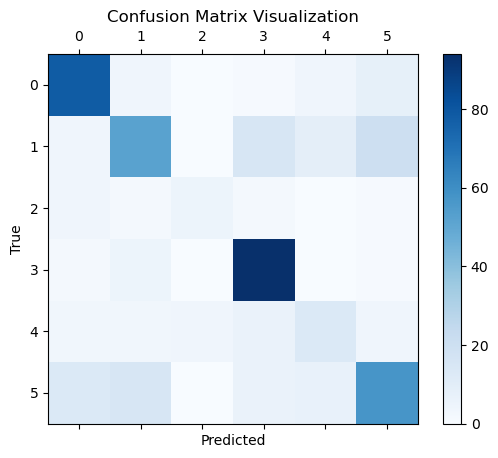

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# 모든 에폭이 끝난 후 테스트 데이터에 대해 실행
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Confusion matrix 계산
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# F1-score 계산, average='macro'는 클래스 불균형을 고려하지 않음
f1 = f1_score(all_labels, all_predictions, average='macro')
print(f"F1-score: {f1}")

# Confusion matrix 시각화
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticklabels([''] + list(range(6)))
ax.set_yticklabels([''] + list(range(6)))
plt.title('Confusion Matrix Visualization')
plt.show()


In [8]:
# 모델 저장
torch.save(model.state_dict(), 'model_best_cnn_33333.pth')


#모델 로드 
#model = SimpleCNN()  # 'SimpleCNN'은 당신이 정의한 모델 클래스
#model.load_state_dict(torch.load('model_best.pth'))
#model.eval()  # 평가 모드로 설정